In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fast_thinning(img):
    skel = np.zeros(img.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    while True:
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = img - open
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skel

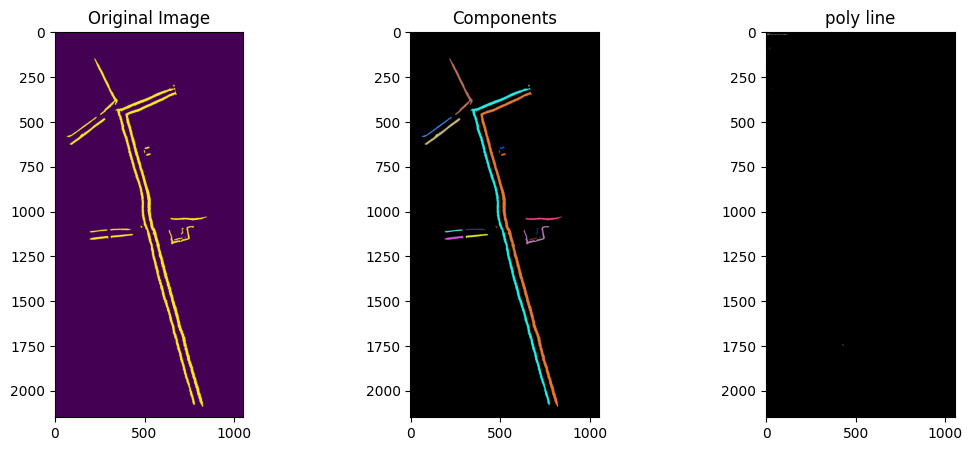

In [29]:
img_path = 'data/class_epoch_79.png'
img = cv2.imread(img_path)
img = img[:,:,::-1]

img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]

# Crear una máscara binaria para detectar píxeles con color verde puro
# En este caso, asumimos que un píxel es verde puro si su canal verde es mayor que los canales rojo y azul
green_mask = np.logical_and(img_green > img_red, img_green > img_blue)
binary_img = green_mask.astype(np.uint8) * 255

# Operaciones morfológicas optimizadas
binary_img = cv2.medianBlur(binary_img, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)


# Análisis de conectividad con filtrado temprano
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
valid_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > 150]

# Pre-alocar arrays
colored_labels = np.zeros_like(img) 
poly_line = np.zeros_like(img)

for i in range(1, num_labels):
    mask = (labels == i)
    colored_labels[mask] = [np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)]

    mask = mask.astype(np.uint8)
    x, y, w, h = cv2.boundingRect(mask)
    roi = mask[y:y+h, x:x+w]

    skeleton = fast_thinning(roi)
    # plt.imshow(roi)
    # plt.show()
    # plt.imshow(skeleton)
    # plt.show()
    
    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = contours[0]
        for j in range(1, len(contour)):
            cv2.line(poly_line, tuple(contour[j-1][0]), tuple(contour[j][0]), (255, 255, 255), 1)

plt.figure(figsize=(13, 5))
# Display the results
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(binary_img)

plt.subplot(1, 3, 2)
plt.title('Components')
plt.imshow(colored_labels)

plt.subplot(1, 3, 3)
plt.title('poly line')
plt.imshow(poly_line)

plt.show()